# Package Imports

In [13]:
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
import networkx as nx
from tqdm.auto import tqdm
import random
import math
import pickle
import torch
from torch import Tensor
import pandas as pd
import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.utils.convert import to_networkx, from_networkx
from torch_geometric.utils import to_undirected, is_undirected
import numpy as np
from networkx import to_dict_of_dicts
from torch_geometric.loader import NeighborLoader, LinkNeighborLoader, HGTLoader,NeighborSampler
from torch_geometric.utils import mask_select, index_to_mask
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import os

In [7]:
# Load New Mapping: 
artist_tracks_mapping = pd.read_csv('data/new_artist_tracks_mapping_df.csv')
artist_tracks_mapping

,Artist,Song_Name,Song_Node_ID
0,Black Kids,I'm Not Gonna Teach Your Boyfriend How to Danc...,3307
1,Black Kids,Hit The Heartbrakes,3308
2,Black Kids,I've Underestimated My Charm (Again),3309
3,Black Kids,Partie Traumatic,3310
4,Black Kids,I'm Making Eyes at You,3311
...,...,...,...
252008,Jamie Lancaster,Boys Don't Cry,255203
252009,Sleeperstar,I Was Wrong,255208
252010,Anthony Naples,Mad Disrespect,255228
252011,Irene,Stardust,255253


# Evaluation Metrics

In [8]:
# import 2 node graph
data = torch.load('data/pyg_data/train_hetero_data_2_nodes_co.pt')

In [9]:
data

HeteroData(
  users={ node_id=[3307] },
  songs={ node_id=[252013] },
  (users, listens_to, songs)={ edge_index=[2, 2564907] },
  (users, is_friends_with, users)={ edge_index=[2, 142919] },
  (songs, rev_listens_to, users)={ edge_index=[2, 2564907] },
  (users, rev_is_friends_with, users)={ edge_index=[2, 142919] }
)

In [10]:
data.num_nodes, data.num_edges

(255320, 5415652)

In [11]:
# transform pyg to nx graph
user_track_graph = to_networkx(data)

In [9]:
len(user_track_graph), len(user_track_graph.edges) # transformation correct form pyg to nx

(255320, 5129814)

## Louvain Communities

In [27]:
from networkx.algorithms.community import louvain_communities
# Define the path to save or load the communities
communities_path = 'data/communities/louvain_communities.pkl'

# Check if the communities file exists
if os.path.exists(communities_path):
    # Load the communities if the file exists
    with open(communities_path, 'rb') as f:
        communities = pickle.load(f)
    print("Communities loaded from file.")
else:
    # Run and save the communities if the file does not exist
    communities = louvain_communities(co_nx, seed=42)
    with open(communities_path, 'wb') as f:
        pickle.dump(l_com, f)
    print("Communities generated and saved to file.")


Communities loaded from file.


In [28]:
print(f'Number of Communities: {len(communities)}')

Number of Communities: 9


#### Community Distribution:

In [29]:
# dictionary that shows all nodes and their assigment to their community (from 0 - 10)
node_community = {}
for c, group in enumerate(communities):
    for u in group:
        node_community[u] = c

In [30]:
len(node_community) - 3307

252013

In [31]:
node_community

{16385: 0,
 188420: 0,
 32778: 0,
 188426: 0,
 188429: 0,
 172046: 0,
 163855: 0,
 32787: 0,
 32788: 0,
 24595: 0,
 57364: 0,
 73748: 0,
 73754: 0,
 49185: 0,
 49187: 0,
 49189: 0,
 73765: 0,
 245802: 0,
 32813: 0,
 213041: 0,
 213043: 0,
 180275: 0,
 213045: 0,
 213047: 0,
 24640: 0,
 81985: 0,
 49226: 0,
 8271: 0,
 65616: 0,
 32849: 0,
 204881: 0,
 32853: 0,
 16471: 0,
 57433: 0,
 90203: 0,
 98396: 0,
 98397: 0,
 122978: 0,
 32876: 0,
 73843: 0,
 24691: 0,
 57460: 0,
 73844: 0,
 65662: 0,
 73864: 0,
 180362: 0,
 57485: 0,
 16528: 0,
 163996: 0,
 229532: 0,
 98462: 0,
 32927: 0,
 172197: 0,
 73897: 0,
 237741: 0,
 172206: 0,
 57519: 0,
 90288: 0,
 172207: 0,
 229558: 0,
 32956: 0,
 229574: 0,
 204998: 0,
 229576: 0,
 8395: 0,
 155852: 0,
 237772: 0,
 155854: 0,
 57547: 0,
 57548: 0,
 57549: 0,
 164050: 0,
 155858: 0,
 155862: 0,
 155864: 0,
 155866: 0,
 57562: 0,
 155868: 0,
 16605: 0,
 155871: 0,
 32994: 0,
 228: 0,
 213220: 0,
 16614: 0,
 213222: 0,
 90340: 0,
 221414: 0,
 221416: 0

In [32]:
com_counter = {community: 0 for community in range(len(communities))}
for com in communities:
    for i in com:
        if i in range(0,3307):
            #print(i)
            #get track community of track ID
            community = node_community.get(i)
            #print(community)
            # count up for the belonging commmunity
            com_counter[community] += 1

In [33]:
com_counter

{0: 11, 1: 71, 2: 8, 3: 225, 4: 526, 5: 933, 6: 808, 7: 4, 8: 721}

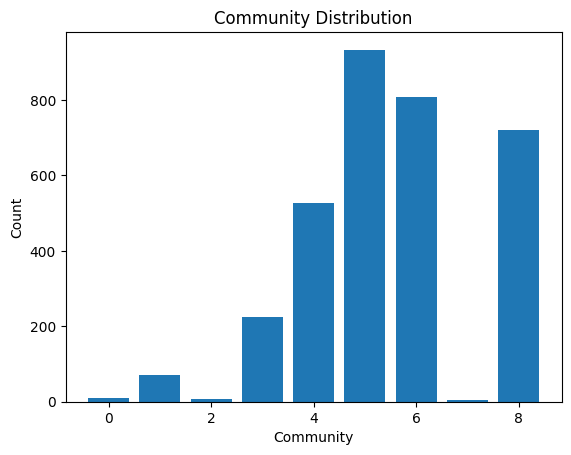

In [34]:
import matplotlib.pyplot as plt

plt.bar(com_counter.keys(), com_counter.values())
plt.xlabel('Community')
plt.ylabel('Count')
plt.title('Community Distribution')
plt.show()


# Structural Dissimilarity:

## Structural Tracks Embedding

### User-Track Graph Embeddings
Consumption rate of songs to user groups are used to calculate structural song embeddings in the length of the user communities defined by louvain (8) in our case

In [36]:
# laod df
train_graph_df = pd.read_csv('data/train_graph_df_clean.csv')
## create TrackID - Track NAme Mapping
song_id_name_dict = dict(zip(train_graph_df['Song_ID'], train_graph_df['Song_Name']))



#### Create Track - User Dictionary:
Mapping of Track ID - to User ID. Which Tracks were listened to by which users.

In [59]:
import os
import pickle

track_user_dict_path = 'data/mappings/track_user_dict.pickle'
user_track_dict_path = 'data/mappings/user_track_dict.pickle'

if os.path.exists(track_user_dict_path):
    with open(track_user_dict_path, 'rb') as f:
        track_user_dict = pickle.load(f)
else:
    users = data["users"].node_id.numpy()
    songs = data["songs"].node_id.numpy()
    edge_index = data["users", "songs"].edge_index.numpy()

    def convert_tensor_to_dict(tensor, reverse=False):
        dictionary = {}
        if reverse:
            targets, sources = tensor
        else:
            sources, targets = tensor
        for source, target in zip(sources.tolist(), targets.tolist()):
            if source not in dictionary:
                dictionary[source] = []
            dictionary[source].append(target)
        return dictionary

    track_user_dict = convert_tensor_to_dict(edge_index, reverse=True)
    user_track_dict = convert_tensor_to_dict(edge_index)

    with open(track_user_dict_path, 'wb') as f:
        pickle.dump(track_user_dict, f)
    with open(user_track_dict_path, 'wb') as f:
        pickle.dump(user_track_dict, f)

In [38]:
# checking if  Track - User Dict is correct
train_graph_df[train_graph_df["Song_ID"] == 2928]

,index,User_ID,Song_ID,Scrobbles,Position,Date,Artist,Song_Name
0,0,0,2928,22,196.0,"Wednesday 22 Sep 2021, 10:41am",Boniface,Making Peace With Suburbia


#### Create Structural Track Embeddings

Reverse Consumptio Rate: Calculates and returns a dictionary containing track consumption rate embeddings. 
"Consumption rate" is defined by: Users are divided into user communities by louvain. User is part of com = 1. Users have listened to a specific list of songs. All songs that have been listened to by that user get a count + 1 in their embedding dimension corresponding to the number if the user community. The embedding lenght of the songs is the same size as the user communities. 


By using the reverse consumption rate, I am essentially creating an embedding that reflects how a track connects to different user communities. This projects the track's popularity or appeal within various user groups.

In [39]:

def rev_consumption_rate_embedding(track_user_dict):
  """
  Calculates and returns a dictionary containing track consumption rate embeddings.

  Args:
      track_user_dict: A dictionary where keys are track IDs and values are lists of users who listened to the track.
      communities: A list containing all community IDs.

  Returns:
      A dictionary where keys are track IDs and values are NumPy arrays representing the normalized consumption rates for each community.
  """
  # Initialize an empty dictionary to store track embeddings
  track_embeddings = {}

  # Iterate over tracks and users
  for track, users in tqdm(track_user_dict.items()):
    # Get track community for each user
    communities_of_users = [node_community.get(user) for user in users]

    # Count occurrences of each community in users' list (using np.bincount)
    community_counts = np.bincount(communities_of_users, minlength=len(communities))

    # Normalize community counts by total users for the track
    total_users = len(users)
    consumption_rate = community_counts / total_users

    # Add track embedding to the dictionary
    track_embeddings[track] = consumption_rate

  return track_embeddings

In [40]:
structural_track_embeddings = rev_consumption_rate_embedding(track_user_dict)

100%|██████████| 252013/252013 [00:00<00:00, 293805.85it/s]


In [41]:
structural_track_embeddings

{2928: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3039: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3153: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3040: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2810: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2610: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2809: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2808: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2927: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2500: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2719: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 4825: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3742: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 4140: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3592: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 4345: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 2867: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 5243: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3121: array([0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 3368: array

In [70]:
# Count embeddings with only one non-zero dimension and those with multiple non-zero dimensions
single_dimension_count = 0
multiple_dimension_count = 0

for embedding in structural_track_embeddings.values():
    non_zero_dimensions = np.count_nonzero(embedding)
    if non_zero_dimensions == 1:
        single_dimension_count += 1
    elif non_zero_dimensions > 1:
        multiple_dimension_count += 1

total_embeddings = len(structural_track_embeddings)

print(f"Total embeddings: {total_embeddings}")
print(f"Embeddings with only one non-zero dimension: {single_dimension_count} ({single_dimension_count/total_embeddings:.2%})")
print(f"Embeddings with multiple non-zero dimensions: {multiple_dimension_count} ({multiple_dimension_count/total_embeddings:.2%})")


Total embeddings: 252013
Embeddings with only one non-zero dimension: 81927 (32.51%)
Embeddings with multiple non-zero dimensions: 170086 (67.49%)


In [42]:
with open('data/embeddings/structural_track_embeddings.pickle', 'wb') as f:
    pickle.dump(structural_track_embeddings, f)

#### Visualize Structural Track Embeddings

In [43]:
from sklearn.manifold import TSNE
import plotly.express as px


def plot_track_embeddings_tsne_plotly(track_embeddings, node_community, song_id_name_dict, sample_size=1000):
  """
  Plots a t-SNE visualization of a sample of track embeddings using Plotly, with song names in hover info.

  Args:
      track_embeddings: A dictionary where keys are track IDs and values are NumPy arrays representing consumption rate embeddings.
      node_community: A dictionary where keys are node IDs (potentially user IDs) and values are community IDs.
      song_id_name_dict: A dictionary where keys are track IDs and values are song names.
      sample_size: Number of track embeddings to sample for visualization (default: 1000).
  """
  # Sample track IDs and embeddings
  sampled_tracks = np.random.choice(list(track_embeddings.keys()), sample_size)
  sampled_embeddings = [track_embeddings[track] for track in sampled_tracks]

  # Reshape embeddings into a 2D array (n_samples, n_features)
  embeddings_array = np.stack(sampled_embeddings)  # Stack embeddings vertically

  # Reduce dimensionality with t-SNE
  tsne = TSNE(n_components=2, random_state=42)  # Adjust n_components and random_state as needed
  tsne_data = tsne.fit_transform(embeddings_array)

  # Extract colors based on node_community
  colors = [node_community.get(track, 0) for track in sampled_tracks]  # Handle missing communities
    
  # Create a dictionary for hover information (including song names)
  hover_data = {"Track ID": sampled_tracks, "Community": colors, "Song Name": [song_id_name_dict.get(t) for t in sampled_tracks]}

  # Create a Plotly Express scatter plot
  fig = px.scatter(x=tsne_data[:, 0], y=tsne_data[:, 1], color=colors,
                   title="t-SNE Visualization of Track Embeddings (Sample)", hover_data=hover_data)

  # Update marker size (optional)
  fig.update_traces(marker=dict(size=10))  # Adjust marker size as needed

  # Set the layout size (optional)
  fig.update_layout(width=1000, height=1000)  # Uncomment for 1000x1000 layout

  # Show the Plotly figure
  fig.show()


In [44]:
# Example usage (assuming you have track_embeddings and node_community)
plot_track_embeddings_tsne_plotly(structural_track_embeddings, node_community, song_id_name_dict,sample_size=1000)

# Content Based Dissimilarity: 

## Data Load and Statistics

In [72]:
train_graph_df = pd.read_csv('data/train_graph_df_clean.csv').rename(columns={"Artist": "Artist", "Song_Name": "Song"})

In [73]:
song_tags_df = pd.read_csv('data/tags_audio/song_tags_df.csv')
song_tags_df = song_tags_df.rename(columns={"Artist": "Artist", "Song_Name": "Song", "Song_Tags": "Tags"})

In [74]:
song_tags_df

,Artist,Song,Tags,Song_ID
0,Black Kids,I'm Not Gonna Teach Your Boyfriend How to Danc...,"indie, indie pop, indie rock, black kids, love...",3307
1,Black Kids,Hit The Heartbrakes,"indie, indie rock, indie pop, rock, catchy",3308
2,Black Kids,I've Underestimated My Charm (Again),"indie, black kids, indie pop, rock, alternative",3309
3,Black Kids,Partie Traumatic,"indie, indie pop, pop, alternative rock, indie...",3310
4,Black Kids,I'm Making Eyes at You,"indie, indie pop, black kids, 2008, pop",3311
...,...,...,...,...
252008,Juveniles,Ambitions,"french, electro, 10s",19818
252009,Daedelus,Get Off Your HiHats,"american i like, electronic, funky, chill, dub...",204002
252010,Floetry,Let Me In,"Neo-Soul, soul, floetry, rnb, smooth",222619
252011,Katatonia,Sleeper,"doom metal, Progressive metal, metal, Progress...",145949


In [75]:
song_tags_df[song_tags_df["Song"].isnull()]

,Artist,Song,Tags,Song_ID


In [76]:
song_tags_df[song_tags_df["Song_ID"] == 68691]

,Artist,Song,Tags,Song_ID


In [77]:
#Same function but wrote it myself
New_Song_ID_dict = {}
new_ID_Counter = 0
missing_id = 68691

for song_id in np.sort(song_tags_df['Song_ID'].unique()):
    #print(song_id)
    if song_id != missing_id:
        
        #new_ID = new_ID_Counter
        New_Song_ID_dict[song_id] = new_ID_Counter
        new_ID_Counter += 1
        #print(New_Song_ID)

#New_Song_ID_dict


In [78]:
# Apply the mapping to the dataset
song_tags_df['Song_ID'] = song_tags_df['Song_ID'].map(New_Song_ID_dict)

In [79]:
song_tags_df[song_tags_df['Song_ID'] == 252012]

,Artist,Song,Tags,Song_ID
97169,BaianaSystem,Capim Guiné,seen live,252012


In [80]:
song_tags_df["Tags"][0]

'indie, indie pop, indie rock, black kids, love at first listen'

In [81]:
song_tags_df

,Artist,Song,Tags,Song_ID
0,Black Kids,I'm Not Gonna Teach Your Boyfriend How to Danc...,"indie, indie pop, indie rock, black kids, love...",0
1,Black Kids,Hit The Heartbrakes,"indie, indie rock, indie pop, rock, catchy",1
2,Black Kids,I've Underestimated My Charm (Again),"indie, black kids, indie pop, rock, alternative",2
3,Black Kids,Partie Traumatic,"indie, indie pop, pop, alternative rock, indie...",3
4,Black Kids,I'm Making Eyes at You,"indie, indie pop, black kids, 2008, pop",4
...,...,...,...,...
252008,Juveniles,Ambitions,"french, electro, 10s",16511
252009,Daedelus,Get Off Your HiHats,"american i like, electronic, funky, chill, dub...",200694
252010,Floetry,Let Me In,"Neo-Soul, soul, floetry, rnb, smooth",219311
252011,Katatonia,Sleeper,"doom metal, Progressive metal, metal, Progress...",142641


In [82]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load your DataFrame
# Assuming your DataFrame is named song_tags_df
# song_tags_df = pd.read_csv("your_dataset.csv")

# Fill NaN values in the 'Tags' column with a special token
song_tags_df['Tags'] = song_tags_df['Tags'].fillna('NaN')

# Split the tags in each row by ","
song_tags_df['Tags'] = song_tags_df['Tags'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Flatten the list of lists into a single list of tags
all_tags = [tag.strip() for tags_list in song_tags_df['Tags'] for tag in tags_list]

# Calculate the number of unique tags (including 'NaN')
unique_tags = set(all_tags)
num_unique_tags = len(unique_tags)

# Calculate the number of NaN tags
num_nan_tags = all_tags.count('NaN')

# Calculate the average, maximum, and minimum appearances of tags
tag_appearances = pd.Series(all_tags).value_counts()
average_appearances = tag_appearances.mean()
max_appearances = tag_appearances.max()
min_appearances = tag_appearances.min()

# Print the results
print("Number of unique tags (including 'NaN'):", num_unique_tags)
print("Number of NaN tags:", num_nan_tags)
print("Average appearances of tags:", average_appearances)
print("Maximum appearances of a tag:", max_appearances)
print("Minimum appearances of a tag:", min_appearances)


Number of unique tags (including 'NaN'): 51724
Number of NaN tags: 160
Average appearances of tags: 22.37769700719202
Maximum appearances of a tag: 55153
Minimum appearances of a tag: 1


In [83]:
# Calculate the average, maximum, and minimum number of tags per row
num_tags_per_row = song_tags_df['Tags'].apply(len)
average_tags_per_row = num_tags_per_row.mean()
max_tags_per_row = num_tags_per_row.max()
min_tags_per_row = num_tags_per_row.min()

# Print the results
print("Average number of tags per row:", average_tags_per_row)
print("Maximum number of tags per row:", max_tags_per_row)
print("Minimum number of tags per row:", min_tags_per_row)


Average number of tags per row: 4.5928741771257835
Maximum number of tags per row: 8
Minimum number of tags per row: 1


## Pre Processing Training Data

In [84]:
# Define functions for preprocessing (optional)
def preprocess_tag(tag):
  # Lowercase, remove punctuation, etc. (implement your desired cleaning)
  return tag.lower().replace(' ', '-').strip()


In [85]:
# Preprocess tags (optional)
preprocessed_tags = [[preprocess_tag(tag) for tag in song_tags] for song_tags in song_tags_df["Tags"]]

In [86]:
len(preprocessed_tags)

252013

In [87]:
preprocessed_tags[0]

['indie', 'indie-pop', 'indie-rock', 'black-kids', 'love-at-first-listen']

## Word 2 Vec Gensim Model

In [88]:
# Import libraries
import numpy as np

# Define statistics for your tags data
num_unique_tags = 51724  # Including NaN
avg_tag_appearances = 22.377697
avg_tags_per_row = 4.592874

# Set vector_size based on the number of unique tags (consider a trade-off between accuracy and efficiency)
vector_size = min(300, int(np.sqrt(num_unique_tags)))  # Adjust upper limit as needed

# Set min_count to filter out very rare tags (considering the average appearances)
min_count = int(max(5, 2 * avg_tag_appearances))  # Adjust multiplier as needed

# Set window size based on the average number of tags per row
window = int(2 * avg_tags_per_row)  # Adjust multiplier as needed

print(f"Recommended parameters:")
print(f"vector_size: {vector_size}")
print(f"min_count: {min_count}")
print(f"window: {window}")
vector_size = 300

Recommended parameters:
vector_size: 227
min_count: 44
window: 9


In [89]:
#train Model
def train_w2c_model(vector_size = 300, min_count = 5, window = 9):
  # Define training parameters
  vector_size = vector_size  # Embedding dimension (adjustable) vector_size:
                      #A common rule of thumb is to set vector_size to be around
                      #the square root of the number of unique tokens.
                      #In your case, with 51724 unique tags (including NaN),
                      #this suggests a vector_size of around sqrt(51724) ≈ 227.

  min_count = min_count  # Minimum tag frequency (filter out rare tags)
                  #This parameter filters out infrequent tags. With an average appearance of 22.38 per tag,
                  #you can set a min_count of at least 5 to filter out very rare tags that might not
                  #contribute much to meaningful embeddings. You can adjust this further based on your data.
                  #For instance, if you have many tags with appearances close to the average (22.38),
                  #you might consider setting min_count to a higher value (e.g., 10) to avoid filtering out potentially useful tags.

  window = window # Context window for capturing tag relationships

  # Train the Word2Vec model on the preprocessed tags
  #model = Word2Vec(preprocessed_tags_flat, vector_size=vector_size, min_count=min_count, window=window) # this gives only 37 embeddings that make sense

  model = Word2Vec(preprocessed_tags, vector_size=vector_size, min_count=min_count, window=window)
  return model


In [90]:
model = train_w2c_model(vector_size = 300, min_count = 5, window = 9)

## Process Embeddings

In [91]:
# Function to get tag embedding
def get_tag_embedding(tag):
  # Preprocess the tag
  preprocessed_tag = preprocess_tag(tag)
  # Check if the tag exists in the vocabulary (trained on)
  if preprocessed_tag in model.wv:
    return model.wv[preprocessed_tag]
  else:
    # Handle unseen tags (e.g., return zero vector)
    return np.zeros(vector_size)  # Replace with your preferred handling


In [92]:
def create_unique_embeddings(preprocessed_tags):
  tags_flat = [item for sublist in preprocessed_tags for item in sublist]
  print(len(tags_flat), "Number of all tags across all songs (non unqiue)") ## all seperated tags of all songs
  tags_flat_set = set(tags_flat) # all unique tags over all songs
  print(len(tags_flat_set), "Number of unique tags across all songs")

  #loop over tags and store embeddings
  tag_embeddings_unique = []
  tags_embedding_mapping = {}


  for tag in tqdm(tags_flat_set):
    current_tag_embedding = get_tag_embedding(tag)
    tag_embeddings_unique.append(current_tag_embedding)
    tags_embedding_mapping[tag] = current_tag_embedding

  return tags_embedding_mapping, tag_embeddings_unique

In [93]:
def count_nonzero_embeddings(embeddings):
    count_nonzero = 0
    for emb in embeddings:
        if any(emb):
            count_nonzero += 1
    return count_nonzero

In [94]:
model = train_w2c_model(vector_size = 300, min_count = 5, window = 9)

tags_embedding_mapping, tag_embeddings_unique = create_unique_embeddings(preprocessed_tags)

# Assuming tag_embeddings is your list of tag embeddings
nonzero_count_list = count_nonzero_embeddings(tag_embeddings_unique)
print("Number of embeddings with at least one non-zero dimension in the list:", nonzero_count_list ,"/", len(tag_embeddings_unique))

1157464 Number of all tags across all songs (non unqiue)
51277 Number of unique tags across all songs


100%|██████████| 51277/51277 [00:00<00:00, 601551.00it/s]


Number of embeddings with at least one non-zero dimension in the list: 9080 / 51277


In [95]:
tags_flat = [item for sublist in preprocessed_tags for item in sublist]

unique_tags, tag_counts = np.unique(tags_flat, return_counts=True)
single_appearance_tags = unique_tags[tag_counts == 1]
print("Number of tags that only appear once over all songs:", len(single_appearance_tags))


Number of tags that only appear once over all songs: 31092


In [96]:
tags_flat = [item for sublist in preprocessed_tags for item in sublist]

unique_tags, tag_counts = np.unique(tags_flat, return_counts=True)
max_four_appearance_tags = unique_tags[tag_counts <= 4]
print("Number of tags that appear a maximum of 4 times over all songs:", len(max_four_appearance_tags))


Number of tags that appear a maximum of 4 times over all songs: 42197


In [97]:
51277  - 42197

9080

this means most tags are not really appearing often, but there are 9k tags that appear a lot.
my idea: if we average tags for each song we ignore the non important tags = the tags with 0 values in all dims,
and are left with the 9k "good" tags like genres hopefully, eg "Rock" etc"

In [98]:
np.array(tag_embeddings_unique).shape

(51277, 300)

In [99]:
len(tag_embeddings_unique[0])

300

In [101]:
# Example usage: Get embedding for a specific tag
tag = "rock"
tag_embedding = get_tag_embedding(tag)
print(f"Embedding for '{tag}': {tag_embedding}")

Embedding for 'rock': [-0.2481667  -0.07970792  0.63635415 -0.20228952 -1.5209972  -0.00857482
  1.1068778   0.11205181 -0.5973965  -1.0289012   0.3331486  -0.47604823
 -0.9805915   0.3088863  -0.15215077  0.22726944  0.39892584  0.5833486
 -0.31184062 -0.7686684  -0.26552293  0.16649748 -0.281003    0.2695509
 -0.6406708  -0.47782323 -0.21597487 -0.565144   -0.6711407   0.00727797
 -0.33750102  0.44795388 -0.50018823  0.38529626  0.54808885 -0.7408688
  0.08570392 -1.4593297   0.87085295 -0.0936271  -0.24918973  0.09241427
  0.09690522 -0.15769728 -0.06336109  0.5194622  -0.46606025  0.2820695
  0.12083843  0.63949406 -0.2845865   0.28756815  0.1593369   0.4631325
 -0.474204    0.20675932  0.5772976   0.3783916   0.3115435   0.30530807
 -0.04657818  0.42130575 -0.46614054 -0.46236357 -0.11606097  0.04040605
 -1.4626671  -0.6794307  -0.10968447  0.62050194  0.07196193  0.774023
  0.12795098  0.29620194  1.1962022   0.3236052   0.32717875  0.02605738
 -0.40495852  0.3307878   0.47898412

## Embedding Quality Check:

## Averaging Song Embeddings
= Content Based Track Embeddings

In [104]:
# Assuming 'song_tags_df' is your DataFrame with songs, artists, and tags
# Assuming 'tags_embedding_mapping' is a dictionary mapping tags to their embeddings
def create_avrg_song_embeddings(song_tags_df, tags_embedding_mapping):

  song_embeddings = {}  # Dictionary to store song and its average embedding

  #iterate over all songs
  for index, row in tqdm(song_tags_df.iterrows(), total=len(song_tags_df)):
    song_id = row["Song_ID"]
    song_name = row["Song"]
    song_tags = row["Tags"]

    #average the tag embeddings per song
    song_embedding_sum = np.zeros(len(tags_embedding_mapping[list(tags_embedding_mapping.keys())[0]]))  # Initialize with zero vector
    for tag in song_tags:
      tag = preprocess_tag(tag)
      if tag in tags_embedding_mapping:  # Handle missing tags (optional)
        song_embedding_sum += tags_embedding_mapping[tag]
      else:
        break
        print(tag, " is not in Embedding Dictionary")

    if len(song_tags) > 0:  # Avoid division by zero (optional)
      average_embedding = song_embedding_sum / len(song_tags)
    else:
      average_embedding = np.zeros_like(song_embedding_sum)  # Assign zero vector for songs with no tags
      print(song_name, song_id, song_tags, " has no Tags")

    song_embeddings[song_id] = average_embedding
  return song_embeddings


In [105]:
# Define the path to save the embeddings
embeddings_path = 'data/embeddings/content_based_track_embeddings.pickle'

# Check if the embeddings file already exists
if os.path.exists(embeddings_path):
    # If it exists, load the embeddings
    with open(embeddings_path, 'rb') as f:
        song_embeddings = pickle.load(f)
    print(f"Embeddings loaded from {embeddings_path}")
else:
    # If not, create the embeddings, save them, and then load
    song_embeddings = create_avrg_song_embeddings(song_tags_df, tags_embedding_mapping)
    with open(embeddings_path, 'wb') as f:
        pickle.dump(song_embeddings, f)
    print(f"Embeddings created and saved to {embeddings_path}")

100%|██████████| 252013/252013 [02:27<00:00, 1706.64it/s]


Embeddings created and saved to data/embeddings/content_based_track_embeddings.pickle


In [107]:
len(song_embeddings)

252013

# Vizualization of Embeddings

In [108]:
len(song_embeddings)

252013

### Select Artists / Songs to Plot

In [109]:
## create TrackID - Track NAme Mapping
song_name_id_dict = dict(zip(song_tags_df['Song_ID'], song_tags_df['Song']))
artist_info = dict(zip(song_tags_df['Artist'], song_tags_df['Song_ID']))
#song_id_name_dict

In [110]:

# Assuming 'songdf' is your DataFrame with Artist and Song_ID columns
song_name_id_dict = {}
artist_info = {}

for index, row in tqdm(song_tags_df.iterrows(), total= len(song_tags_df)):
  artist_name = row["Artist"]
  song_id = row["Song_ID"]
  song_name = row["Song"]

  # Check if artist exists in the dictionary
  if artist_name not in artist_info:
    artist_info[artist_name] = []  # Initialize an empty list for song IDs

  # Append song ID to the artist's list
  artist_info[artist_name].append(song_id)
  song_name_id_dict[song_id] = song_name

# Now 'artist_info' is a dictionary with {artist: [song_ID1, song_ID2, ...]} structure


100%|██████████| 252013/252013 [00:03<00:00, 69129.75it/s]


In [111]:
artists = ['Black Kids', 'Taylor Swift', 'Slipknot', 'Linkin Park', 'Red Hot Chili Peppers', 'Falco', 'Miles Davis', 'Martin Garrix', "John Coltrane", "Foo Fighters", "Johann Sebastian Bach" ]

In [112]:
#artist_info['Taylor Swift']

In [113]:
selected_songs = []
selected_artists = {}
# not working yet
color_map = {}

for artist in artists:
  for idx in artist_info[artist]:
    #print(idx)
    selected_songs.append(idx)
    selected_artists[idx] = artist

    #color_map[artist] = cm.get_cmap('tab10')
#selected_songs

In [114]:
# Define a list of song IDs for comparison (replace with your choices from different artists)

selected_song_embeddings = []
for song_id in selected_songs:
  selected_song_embeddings.append(song_embeddings[song_id])

selected_song_embeddings = np.array(selected_song_embeddings)

In [115]:
selected_song_embeddings.shape

(1146, 300)

In [116]:
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'black', 'white',
          'cyan', 'magenta', 'lime', 'pink', 'teal', 'aqua', 'fuchsia', 'gray',
          'maroon', 'navy', 'olive', 'silver']  # Added more colors

artist_colors = {}
for artist in artists:
  # Check if colors are still available
  if colors:
    color = colors.pop()  # Pop removes and returns the last element
    artist_colors[artist] = color
  else:
    print(f"Not enough colors for all artists. Assigning 'gray' to {artist}")
    artist_colors[artist] = 'gray'

### Genre Embeddings

In [117]:
# Genre List:
genres = ["pop", "rock", "jazz", "indie", "classic", "electronic", "metal", "blues", "alternative", "ambient", "Hip-Hop", "instrumental"]

In [118]:
genre_colors = {}
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'orange', 'black', 'white',
          'cyan', 'magenta', 'lime', 'pink', 'teal', 'aqua', 'fuchsia', 'gray',
          'maroon', 'navy', 'olive', 'silver']
for i, genre in enumerate(genres):
    color = colors[i % len(colors)]  # Use modulo to cycle through colors if genres exceed available colors
    genre_colors[genre] = color


In [119]:
genre_colors

{'pop': 'red',
 'rock': 'blue',
 'jazz': 'green',
 'indie': 'purple',
 'classic': 'yellow',
 'electronic': 'orange',
 'metal': 'black',
 'blues': 'white',
 'alternative': 'cyan',
 'ambient': 'magenta',
 'Hip-Hop': 'lime',
 'instrumental': 'pink'}

In [120]:
genre_embeddings = []
for genre in genres:
  genre_embeddings.append(get_tag_embedding(genre))

genre_embeddings = np.array(genre_embeddings)


### T-SNE Dim reduction 2D

In [121]:
from sklearn.preprocessing import MinMaxScaler

# Assuming song_embeddings and genre_embeddings are your data structures
scaler = MinMaxScaler()  # Create a MinMaxScaler object
scaled_song_embeddings = scaler.fit_transform(selected_song_embeddings)
scaled_genre_embeddings = scaler.fit_transform(genre_embeddings)

# Combine scaled embeddings
combined_embeddings = np.concatenate((scaled_song_embeddings, scaled_genre_embeddings), axis=0)

# Perplexity (adjust as needed)
perplexity = 10  # Experiment with different values

# Run t-SNE on combined data
tsne_model = TSNE(n_components=2, perplexity=perplexity)
combined_embeddings_2d = tsne_model.fit_transform(combined_embeddings)

# Extract separate embeddings for visualization (optional)
song_embeddings_2d = combined_embeddings_2d[:len(selected_song_embeddings)]  # Assuming song embeddings come first
genre_embeddings_2d = combined_embeddings_2d[len(selected_song_embeddings):]

# Use song_embeddings_2d and genre_embeddings_2d for plotting


### Plotting

In [122]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import colorsys

# Function to generate distinct colors
def generate_distinct_colors(n):
    HSV_tuples = [(x * 1.0 / n, 0.5, 0.5) for x in range(n)]
    RGB_tuples = [colorsys.hsv_to_rgb(*x) for x in HSV_tuples]
    return ['rgb({},{},{})'.format(int(r*255), int(g*255), int(b*255)) for r, g, b in RGB_tuples]

# Assuming genre_embeddings_2d, song_embeddings_2d, genres, artist_colors, selected_songs, selected_artists, and song_name_id_dict are already defined

# Create figure
fig = make_subplots(rows=1, cols=1)

# Generate colors for genres
genre_colors = generate_distinct_colors(len(genres))

# Genre bubbles
for i, genre in enumerate(genres):
    fig.add_trace(go.Scatter(
        x=[genre_embeddings_2d[i][0]],
        y=[genre_embeddings_2d[i][1]],
        mode='markers+text',
        marker=dict(
            size=100,
            color=genre_colors[i],
            opacity=0.3,
            line=dict(width=2, color=genre_colors[i])
        ),
        text=genre,
        textposition="middle center",
        name=genre,
        hoverinfo='text',
        showlegend=False
    ))

# Songs by artist
for artist in set(selected_artists.values()):
    artist_songs = [song_id for song_id, art in selected_artists.items() if art == artist]
    x = [song_embeddings_2d[selected_songs.index(song_id)][0] for song_id in artist_songs]
    y = [song_embeddings_2d[selected_songs.index(song_id)][1] for song_id in artist_songs]
    text = [f"{artist} - {song_name_id_dict.get(song_id, 'Unknown')}" for song_id in artist_songs]
    
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        marker=dict(
            size=8,
            color=artist_colors.get(artist, 'gray'),
            line=dict(width=1, color='DarkSlateGrey')
        ),
        text=text,
        name=artist,
        hoverinfo='text',
        showlegend=True
    ))

# Update layout
fig.update_layout(
    title="t-SNE Visualization of Songs and Genres",
    xaxis_title="t-SNE Dimension 1",
    yaxis_title="t-SNE Dimension 2",
    legend_title="Artists",
    hovermode='closest',
    updatemenus=[
        dict(
            type="buttons",
            direction="left",
            buttons=list([
                dict(
                    args=[{"visible": [True] * len(fig.data)}],
                    label="Show All",
                    method="update"
                ),
                dict(
                    args=[{"visible": [True] * len(genres) + [False] * (len(fig.data) - len(genres))}],
                    label="Hide All Artists",
                    method="update"
                )
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.11,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
    ],
    width=1000,
    height=800,
    template="plotly_white"
)

# Show the plot
fig.show()